In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import PHELPH


In [635]:
system = PHELPH.PHELPH(kmax=2.0, n_kmax=80)

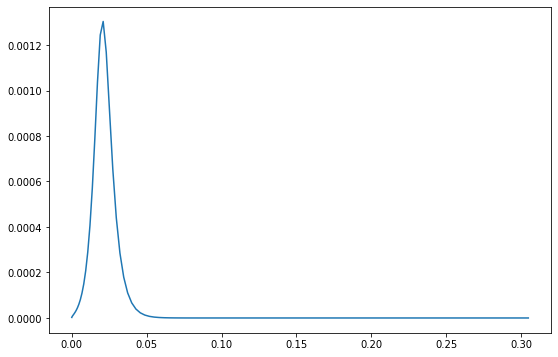

In [636]:
plt.plot(system.E_el_vec,system.I_gain_helper_vec)
plt.show()

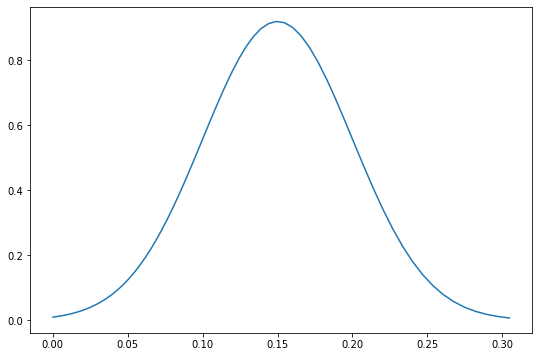

In [637]:
inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.12)

plt.plot(system.E_el_vec,inits[:system.n_kmax])
plt.show()

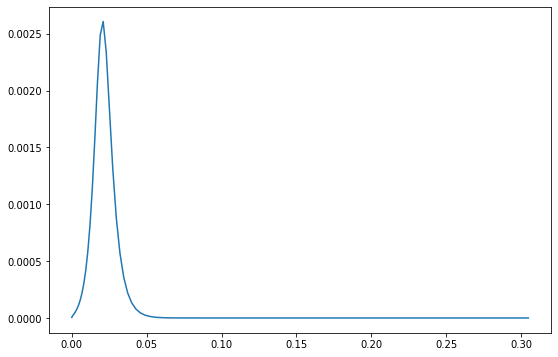

In [664]:
# system.g_photon = 0.05
# system.tau_photon = 50
# system.E_photon = 0.02
# system.linewidth = 0.002

system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.02
system.linewidth = 0.005

system.setup_laser()

plt.plot(system.E_el_vec,system.I_gain_helper_vec)
plt.show()

In [665]:
trajectory = system.get_full_trajectory(inits, tmax=10000, n_tmax=1001)

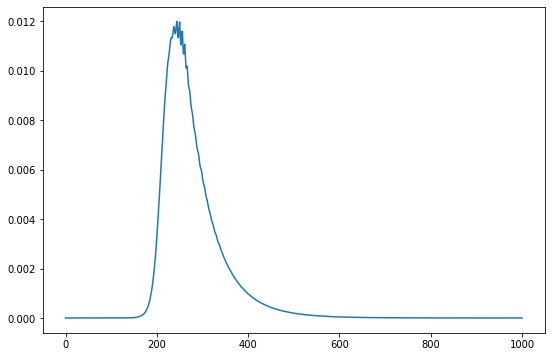

In [666]:
# plt.plot(old)
# old = trajectory[:,-1]

plt.plot(trajectory[:,-1])
plt.show()

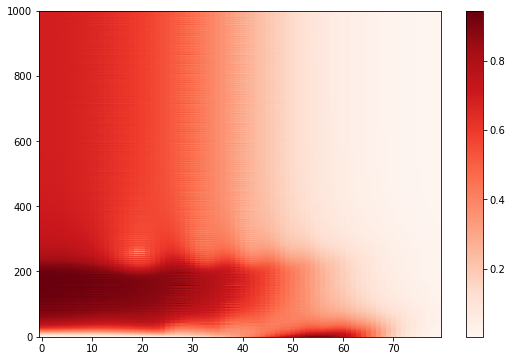

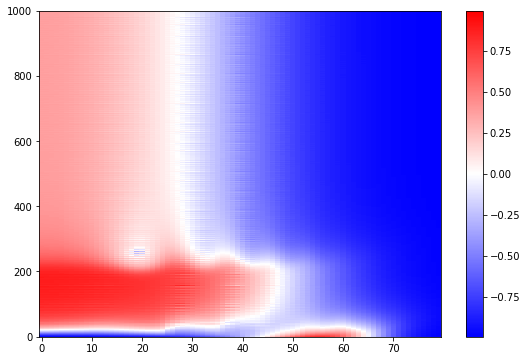

In [667]:
import matplotlib.colors as colors

plt.imshow(trajectory[:,:system.n_kmax], aspect='auto', interpolation='none', origin='lower',cmap='Reds')
plt.colorbar()
plt.show()


inversion = 2*trajectory[:,:system.n_kmax] - 1.

plt.imshow(inversion, aspect='auto', interpolation='none', origin='lower',
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

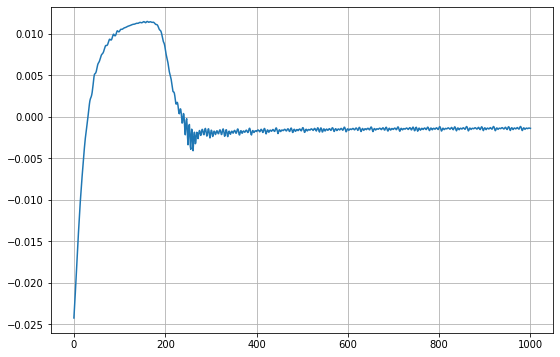

In [668]:
gain = [system.get_net_photon_gain(el_state) for el_state in trajectory[:,:system.n_kmax] ]


plt.grid()
plt.plot(gain)
plt.show()

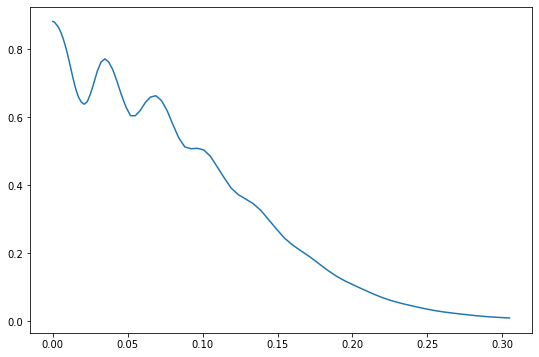

In [669]:
plt.plot(system.E_el_vec,trajectory[220,:system.n_kmax])
plt.show()

In [ ]:
x = np.linspace(-10,10,1000)
dx = x[1]-x[0]

def lineshape(delta_E, width):
    return (1/(np.pi*width))/(np.cosh(x/width))

y = lineshape(x,0.9)

print(np.sum(y)*dx)

plt.plot(x,y)
plt.show()

In [ ]:

trajectory = system.integrate(inits, n_steps=11, dt=0.02, dt_out=5.0)